In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

np.random.seed(333)

df = pd.read_csv('./data/merged_probs_odds.csv') # labels: "home wins" -> 1; "draw": 0; "away" -> -1
df = df.sort_values("date_x", ascending = True)

rename_dict = {"date_x":"date", "prob_tie": "prob_draw", "label":"result"}
df = df.rename(columns=rename_dict)

df['proj_diff_score'] = df['proj_home_score'] - df['proj_away_score']
df['proj_outcome'] = np.clip(np.round(df['proj_away_score'] - df['proj_home_score']), -1, 1).astype(int) + 1
df['result'] = df['result'].map({1: 0, -1: 2, 0: 1}) # 0 = home; 1 = draw; 2 = away
df.tail(10)

,date,date_y,year,country,league,home_team,away_team,spi1,spi2,prob_home,...,odds_home,odds_draw,odds_away,proj_home_score,proj_away_score,home_goals,away_goals,result,proj_diff_score,proj_outcome
10737,2023-05-07,7/5/2023,2023,Sweden,Swedish Allsvenskan,Malmo FF,AIK,48.85,28.68,0.6843,...,1.50,4.15,6.55,1.98,0.62,3,1,0,1.36,0
10733,2023-05-07,7/5/2023,2023,Argentina,Argentina Primera Division,Rosario Central,Platense,37.30,33.60,0.4568,...,2.03,3.11,4.03,1.36,0.95,4,0,0,0.41,1
10732,2023-05-07,7/5/2023,2023,Norway,Norwegian Tippeligaen,Aalesund,Haugesund,19.22,24.12,0.4177,...,2.05,3.24,3.73,1.34,1.06,0,0,1,0.28,1
10734,2023-05-07,7/5/2023,2023,Norway,Norwegian Tippeligaen,Lillestrom,Bodo/Glimt,38.18,61.04,0.2289,...,2.93,3.56,2.27,1.30,2.08,1,2,2,-0.78,2
10739,2023-05-08,9/5/2023,2023,Brazil,Brasileiro Série A,Corinthians,Fortaleza,54.23,53.25,0.4860,...,2.55,3.06,2.93,1.53,1.02,1,1,1,0.51,0
10740,2023-05-08,2/4/2022,2022,England,English League Championship,Birmingham,Sheffield United,38.07,54.97,0.3132,...,3.86,3.41,2.00,1.09,1.29,1,2,2,-0.20,1
10738,2023-05-08,8/5/2023,2023,Argentina,Argentina Primera Division,San Lorenzo,Defensa y Justicia,45.00,43.75,0.4500,...,2.17,2.98,3.75,1.21,0.81,0,0,1,0.40,1
10741,2023-05-09,9/5/2023,2023,Sweden,Swedish Allsvenskan,Hammarby,Mjallby,37.31,21.67,0.5602,...,1.67,3.74,5.26,1.69,0.86,0,0,1,0.83,0
10742,2023-05-10,11/5/2023,2023,Brazil,Brasileiro Série A,Cruzeiro,Fluminense,45.37,58.56,0.3419,...,2.62,3.15,2.76,1.38,1.52,0,2,2,-0.14,1
10743,2023-05-14,5/14/2022,2022,Italy,Italy Serie A,Verona,Torino,52.92,66.14,0.3544,...,2.31,3.48,3.10,1.07,1.04,0,1,2,0.03,1


In [43]:
from tqdm import tqdm

def make_trajectories(df, trajectory_len=5, keep_cols=['date', 'home_team', 'away_team', 'spi1', 'spi2', 'prob_home',
                                                        'prob_draw', 'prob_away', 'odds_home', 'odds_draw', 'odds_away',
                                                        'proj_home_score', 'proj_away_score', 'proj_diff_score', 'proj_outcome', 'result']):
    num_traj = int(df.shape[0] // trajectory_len)
    trajectories = []
    for _ in tqdm(range(num_traj)):
        df = df.sample(frac=1.0) # shuffle
        traj = df.iloc[:trajectory_len] # keep first {traj_len} random games
        traj = traj.sort_values(by='date', ascending=True) # make game sample chronologic
        trajectories.append(traj[keep_cols])
    return trajectories

In [44]:
traj_list = make_trajectories(df, trajectory_len=5)
len(traj_list)

100%|██████████| 2148/2148 [00:06<00:00, 328.83it/s]


2148

In [45]:
train_list, test_list = traj_list[:1718], traj_list[1718:] # 1718 if using len=5
train_list[0].head()

,date,home_team,away_team,spi1,spi2,prob_home,prob_draw,prob_away,odds_home,odds_draw,odds_away,proj_home_score,proj_away_score,proj_diff_score,proj_outcome,result
4015,2019-09-21,Benevento,Cosenza,34.06,21.37,0.5811,0.2684,0.1505,1.60,3.62,6.03,1.77,0.77,1.00,0,0
6112,2020-11-28,Blackburn,Barnsley,53.43,45.44,0.4907,0.2778,0.2315,1.92,3.51,4.03,1.54,0.97,0.57,0,0
8170,2021-11-21,Platense,River Plate,29.62,60.54,0.1400,0.2134,0.6466,7.77,4.50,1.40,0.78,1.96,-1.18,2,2
8193,2021-11-23,Rochdale,Stevenage,10.69,6.05,0.5317,0.2690,0.1994,2.06,3.38,3.57,1.52,0.82,0.70,0,1
8845,2022-06-10,Lanus,Defensa y Justicia,41.55,45.19,0.4003,0.2435,0.3562,3.29,3.08,2.30,1.62,1.52,0.10,1,1


Trial #4: Fixed Baselines, train policy using PPO2

Sources:

https://colab.research.google.com/drive/1eqODB6TYWUaPq-SG1LD8kVcw1VMqEUyU#scrollTo=juMw2p58Jv8r 

https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/master/3_multiprocessing.ipynb#scrollTo=AvO5BGrVv2Rk 

https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html

In [46]:
from oddsgym.envs.base_percentage import BasePercentageOddsEnv
from stable_baselines.common import set_global_seeds

Trial #5: Percentage Baselines, train policy using PPO2

In [47]:
CONSTRAINT = 0.05

def make_perc_env(train_trajectories, train_feats, env_id, rank, constraint=CONSTRAINT, seed=0):
    """
    Utility function for multiprocessed env.
    :param train_trajectories: (list of DataFrames) list with the trajectories to be used for training
    :param train_feats (list of str) the name of the features in the DFs above for the agent to learn from
    :param env_id: (str) the environment ID
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _init():
        main_df = train_trajectories[env_id][train_feats]
        results_df = train_trajectories[env_id]["result"].tolist()
        env = BasePercentageOddsEnv(main_df=main_df, odds_column_names=["odds_home", "odds_draw", "odds_away"], 
                                    num_possible_outcomes=3, results=results_df, constraining=constraint)
        env.seed(seed + rank)
        return env
    set_global_seeds(seed)
    return _init

In [48]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines import PPO2, ACKTR

In [49]:
def train_agent(train_list, train_feats, max_steps=30000, constraint=CONSTRAINT):
    num_traj = len(train_list)
    learning_env = DummyVecEnv([make_perc_env(train_list, train_feats, i, i, constraint=constraint) for i in range(num_traj)])
    model = PPO2(MlpPolicy, learning_env, verbose=1) # could be parameter searched!!
    model.learn(total_timesteps=max_steps)
    return model

def evaluate_agent(model, test_list, train_feats, starting_balance=1000, constraint=CONSTRAINT, NUM_SIMULATIONS=20):
    #Test model and append total ending rewards 
    eps_length = test_list[0].shape[0]
    num_traj = len(test_list)
    rewards = np.zeros((num_traj, NUM_SIMULATIONS))
    for j in range(NUM_SIMULATIONS):
        for i in range(num_traj):
            main_df = test_list[i][train_feats]
            results = test_list[i]["result"].tolist()
            env = BasePercentageOddsEnv(main_df=main_df, odds_column_names=["odds_home", "odds_draw", "odds_away"],
                                        num_possible_outcomes=3, results=results, starting_bank=starting_balance, constraining=constraint)
            obs = env.reset()
            for _ in range(eps_length):
                action, _ = model.predict(obs.reshape((1, -1)))
                obs, reward, done, info = env.step(action)
                if done:
                    rewards[i][j] = info['balance']
                    break
    mean_rewards = np.mean(rewards, axis=0) # over each simulation
    return mean_rewards, rewards

def visualize_performance(rewards, starting_balance, NUM_SIMULATIONS, CONSTRAINT):
    mean_return = round(np.mean(rewards), 2)
    plt.hist(rewards)
    plt.title(f'Multi-Outcome PPO2 \n Ending Bankroll for {NUM_SIMULATIONS} Simulations \n Mean: ${mean_return} \n Constraint: {100*CONSTRAINT}%')
    plt.plot([starting_balance, starting_balance], [0, NUM_SIMULATIONS], 'r--', label='starting balance')
    plt.plot([mean_return, mean_return], [0, NUM_SIMULATIONS], 'b--', label='mean ending return')
    plt.legend(loc='best')
    plt.xlabel('ending amount ($)')
    plt.ylabel('frequency')
    plt.show()

In [50]:
starting_balance = 1000
NUM_SIMULATIONS = 100

train_feats = ['spi1', 'spi2', 'prob_home', 'prob_draw', 'prob_away', 'odds_home', 'odds_draw', 'odds_away',
               'proj_home_score', 'proj_away_score', 'proj_diff_score', 'proj_outcome']

step_values = np.arange(25000, 31000+1, 2000)
mean_rewards = np.zeros(len(step_values))
median_rewards = np.zeros(len(step_values))
std_rewards = np.zeros(len(step_values))

for i in tqdm(range(len(step_values))):
    st = step_values[i]
    agent = train_agent(train_list, train_feats, max_steps=st, constraint=CONSTRAINT)
    rewards, _ = evaluate_agent(agent, test_list, train_feats, starting_balance=starting_balance, NUM_SIMULATIONS=NUM_SIMULATIONS, constraint=CONSTRAINT)
    mean_rewards[i] = np.mean(rewards)
    median_rewards[i] = np.median(rewards)
    std_rewards[i] = np.std(rewards)

100%|██████████| 4/4 [15:07<00:00, 226.98s/it]


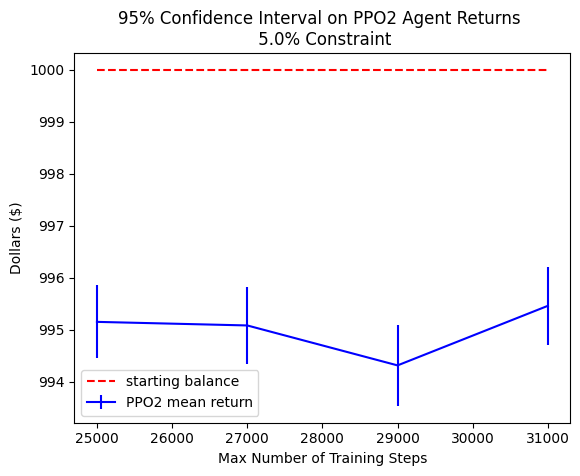

In [51]:
model_used = "PPO2"

kelly_avg = 868.01

plt.errorbar(step_values, mean_rewards, yerr=(1.96/np.sqrt(NUM_SIMULATIONS))*std_rewards, c='blue', label=f'{model_used} mean return')
# plt.plot(step_values, median_rewards, c='green', label='median return')
plt.plot([step_values[0], step_values[-1]], [starting_balance, starting_balance], 'r--', label='starting balance')
# plt.plot([step_values[0], step_values[-1]], [kelly_avg, kelly_avg], 'g--', label='Kelly mean return')
plt.title(f'95% Confidence Interval on {model_used} Agent Returns \n {100*CONSTRAINT}% Constraint')
plt.xlabel('Max Number of Training Steps')
plt.ylabel('Dollars ($)')
plt.legend(loc='best')

In [83]:
import matplotlib.pyplot as plt

best_steps = 22000

agent = train_agent(train_list, train_feats, max_steps=best_steps, constraint=CONSTRAINT)
rewards, _ = evaluate_agent(agent, test_list, train_feats, starting_balance=starting_balance, NUM_SIMULATIONS=len(traj_list), constraint=CONSTRAINT)

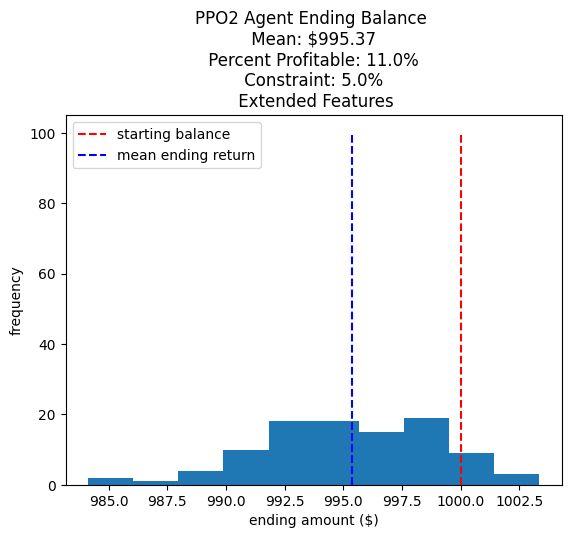

In [53]:
mean_return = round(np.mean(list(sorted(rewards))[:-1]), 2) 
above = round(100*np.sum(np.array(rewards) > starting_balance) / len(rewards), 2) 
plt.hist(list(sorted(rewards))[:-1])
# plt.title(f'{"Single" if use_single_outcome else "Multi"}-Outcome Kelly \n Ending Bankroll for {NUM_SIMULATIONS} Simulations \n Mean: ${mean_return} \n Percent Above: {above}% \n Constraint: {100*CONSTRAINT}%')
plt.title(f'{model_used} Agent Ending Balance \n Mean: ${mean_return} \n Percent Profitable: {above}% \n Constraint: {100*CONSTRAINT}% \n Extended Features')
plt.plot([starting_balance, starting_balance], [0, 100], 'r--', label='starting balance')
plt.plot([mean_return, mean_return], [0, 100], 'b--', label='mean ending return')
plt.legend(loc='best')
plt.xlabel('ending amount ($)')
plt.ylabel('frequency')
plt.show()